# Brain Tumors Image Classification

**🔬Overview**  
**Problem:** Cancer is a leading cause of death worldwide, accounting for nearly 10 million deaths in 2020 (1). To reduce these deaths, technology needs to be used to help in early cancer detection and proper diagnosis.

Deep learning using models such as CNN can be beneficial in cancer and tumors detections through image classification.

This projects explores the use of different CNN models such as VGG19 and EfficientNet in brain tumors classification using MRI scans data. 

## Import libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 862.0 kB/s eta 0:00:00a 0:00:01


In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model,Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import Model
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.layers import Input,Conv2D, Flatten,MaxPooling2D,GlobalAveragePooling2D


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


sns.set_style('darkgrid')

# Ignore future warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

2024-05-27 15:42:06.562344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 15:42:06.562476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 15:42:06.712598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [5]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.random.set_seed(seed)

seed_everything()

## Load Data

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-05-27 15:42:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-27 15:42:20 (68.6 MB/s) - 'helper_functions.py' saved [10246/10246]



In [7]:
# Walk through each directory
data_folder = "/kaggle/input/brain-tumor"
walk_through_dir(data_folder)

There are 1 directories and 0 images in '/kaggle/input/brain-tumor'.
There are 2 directories and 0 images in '/kaggle/input/brain-tumor/archive (5)'.
There are 0 directories and 2098 images in '/kaggle/input/brain-tumor/archive (5)/no'.
There are 0 directories and 5178 images in '/kaggle/input/brain-tumor/archive (5)/yes'.


In [8]:
# Creating a series with label and filepath for all the images
def convert_path_to_df(data_folder):
    image_dir = Path(data_folder)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(data_folder)

In [9]:
# first five records
image_df.head()

,Filepath,Label
0,/kaggle/input/brain-tumor/archive (5)/no/N20.JPG,no
1,/kaggle/input/brain-tumor/archive (5)/no/N1.JPG,no
2,/kaggle/input/brain-tumor/archive (5)/no/N26.JPG,no
3,/kaggle/input/brain-tumor/archive (5)/no/N22.JPG,no
4,/kaggle/input/brain-tumor/archive (5)/no/N19.JPG,no


In [10]:
# shape of the series
image_df.shape

(7274, 2)

In [11]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(data_folder).rglob("*.jpeg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

There are no corrupted images within the dataset

## Exploratory Data Analysis

In [12]:
# Check the number of images per label
image_df['Label'].value_counts()

Label
yes    5177
no     2097
Name: count, dtype: int64

In [13]:
def load_images(folders, label_map):
    # creating two lists to store the images and labels
    images = []
    labels = []
    
    # loading the images from each folder in the dataset
    for folder in folders:
        for category in os.listdir(folder):
            category_path = os.path.join(folder, category)
            if os.path.isdir(category_path):
                if category in label_map:  # Check if the category is present in the label_map
                    label = label_map[category]
                    file_list = os.listdir(category_path)
                    for filename in file_list:
                        img_path = os.path.join(category_path, filename)
                        image = cv2.imread(img_path)
                        # resizing the images to create a standard and so that it can be suitable for the model input
                        image = cv2.resize(image, (224, 224))
                        # cv2 reads the image as BGR so we need to convert it back to RGB
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)
    
    return np.array(images), np.array(labels)



In [14]:
data_folders = [
    '/kaggle/input/brain-tumor/archive (5)',
]

# encoding the labels 
label_map = {'no': 0, 'yes': 1}  # Map negative to 0 (no) and positive to 1 (yes)

images, labels = load_images(data_folders, label_map)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (7276, 224, 224, 3)
Shape of labels: (7276,)


In [15]:
images[1]

array([[[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], dtype=uint8)

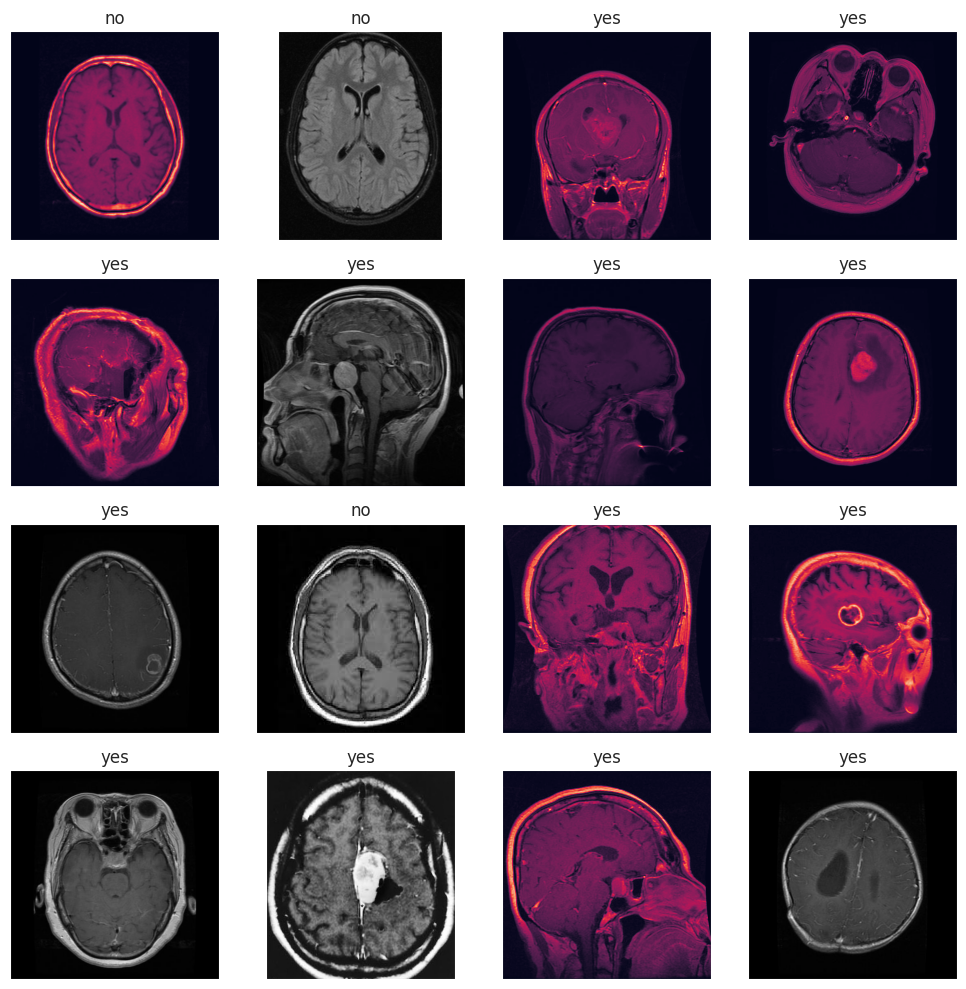

In [16]:
# Display 20 random picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

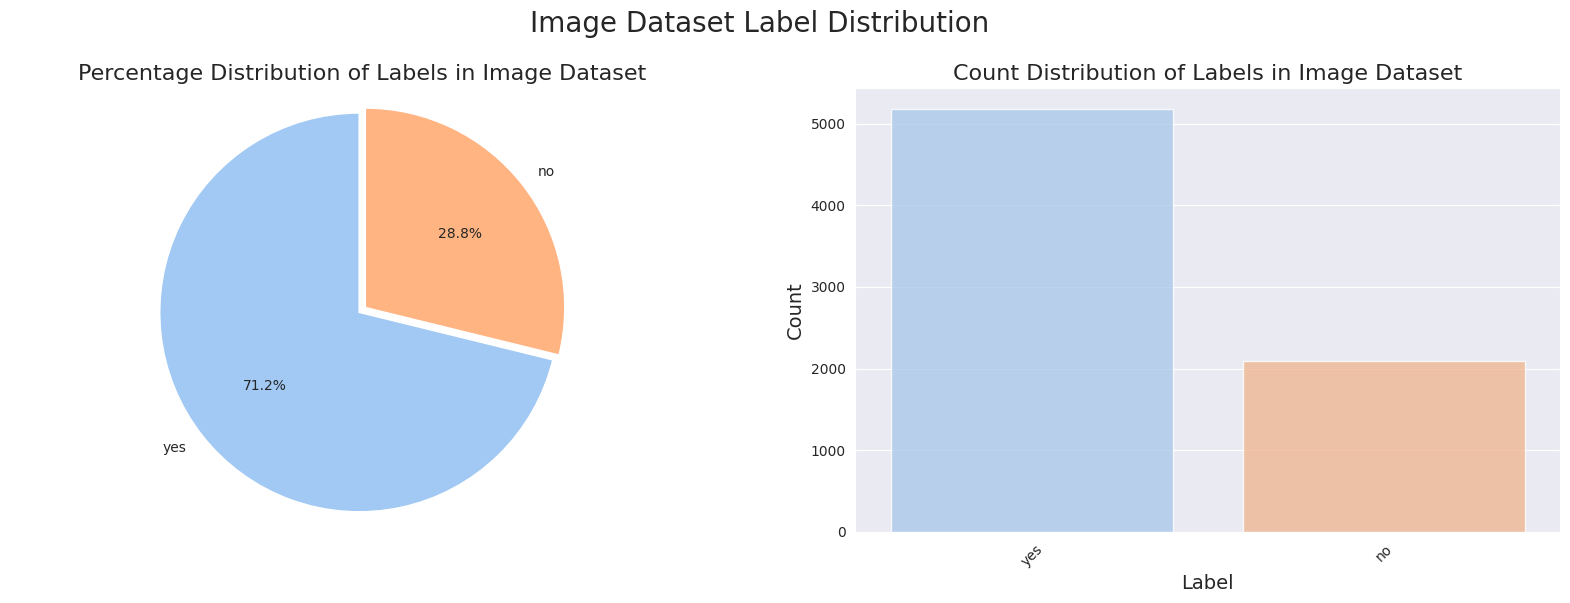

In [17]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define the color palette for the pie chart
colors = sns.color_palette('pastel', len(label_counts))

# Plot the pie chart with percentages, colors, and separation
explode = [0.02] * len(label_counts)  # Define separation values for each pie slice
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axes[0].set_title('Percentage Distribution of Labels in Image Dataset', fontsize=16)

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes[1])
axes[1].set_title('Count Distribution of Labels in Image Dataset', fontsize=16)
axes[1].set_xlabel('Label', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

## Data Preprocessing

In [18]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [19]:
# Split the data to train and test data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2,shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [20]:
# Print the train and test datasets shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5820, 224, 224, 3)
X_val shape: (728, 224, 224, 3)
X_test shape: (728, 224, 224, 3)
y_train shape: (5820,)
y_val shape: (728,)
y_test shape: (728,)


In [22]:
# Separate the datasets to respective folders
train_folder = 'Train'
val_folder = 'Validation'
test_folder = 'Test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

label_map_decoded = {1: 'yes', 0: 'no'}

def copy_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = label_map_decoded[label]
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        img_filename = f'{class_name}_{i}.jpg'  # Assuming images are in JPG format
        img_path = os.path.join(class_folder, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Save image directly without converting to PIL format




In [23]:
copy_images_to_folder(X_train, y_train, train_folder)
copy_images_to_folder(X_val, y_val, val_folder)
copy_images_to_folder(X_test, y_test, test_folder)


## Image Normalization

In [24]:
# Check the max ranges
print(np.max(X_train))
print(np.min(X_train))

255
0


In [25]:
# Normalize to fit between [0,1]
X_train_scaled=X_train/255
X_test_scaled=X_test/255
X_val_scaled=X_val/255

In [26]:
print(np.max(X_train_scaled))
print(np.min(X_train_scaled))

1.0
0.0


In [27]:
len(X_train_scaled)

5820

## Model Training
- Basic CNN (batch_size = 32)
- Basic CNN (batch_size = 64)
- VGG19
- EfficientNet

In [28]:
# Creating the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None


### 1. Creating a model using a batch_size of 32

In [29]:
epochs = 50 
batch_size = 32 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting

class_weights = {
  "yes": 0.7,  # Higher weight for brain tumors
  "no": 1.0   # Lower weight for normal brains
}

history = model.fit(X_train_scaled,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled,y_val),
                   callbacks=[early_stopping],
                   class_weight=class_weights)

Epoch 1/50
  3/182 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6076 - loss: 0.6962

I0000 00:00:1716824635.240336     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716824635.258017     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7856 - loss: 0.4798

W0000 00:00:1716824654.937866     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.7860 - loss: 0.4791 - val_accuracy: 0.9231 - val_loss: 0.2044
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9110 - loss: 0.2074 - val_accuracy: 0.9190 - val_loss: 0.1633
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9312 - loss: 0.1592 - val_accuracy: 0.9341 - val_loss: 0.1408
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9386 - loss: 0.1451 - val_accuracy: 0.9519 - val_loss: 0.1368
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9533 - loss: 0.1173 - val_accuracy: 0.9588 - val_loss: 0.1180
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9608 - loss: 0.0968 - val_accuracy: 0.9629 - val_loss: 0.1021
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9703 - loss: 0.0871 - val_accuracy: 0.9657 - val_loss: 0.0980
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9737 - loss: 0.0706 - val_accuracy: 0.9

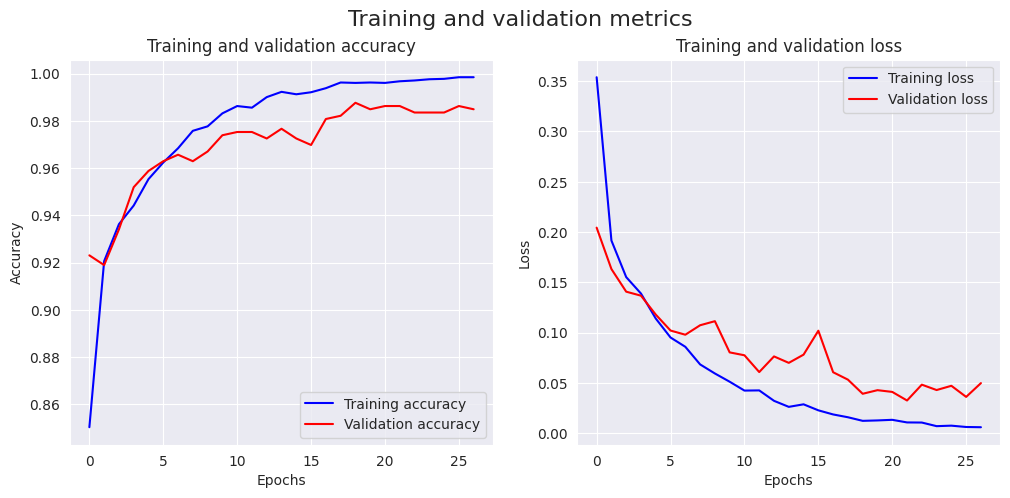

In [30]:
# Plotting training and validation accuracy and loss plots
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

### 2. Trying a batch_size of 64

In [31]:
epochs = 50 
batch_size = 64

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting

class_weights = {
  "yes": 0.7,  # Higher weight for brain tumors
  "no": 1.0   # Lower weight for normal brains
}

history = model.fit(X_train_scaled,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled,y_val),
                   callbacks=[early_stopping],
                   class_weight=class_weights)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9876 - val_loss: 0.0309
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9849 - val_loss: 0.0400
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9876 - val_loss: 0.0607
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9976 - loss: 0.0074 - val_accuracy: 0.9863 - val_loss: 0.0508
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9997 - loss: 0.0025 - val_accuracy: 0.9849 - val_loss: 0.0523
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9863 - val_loss: 0.0440


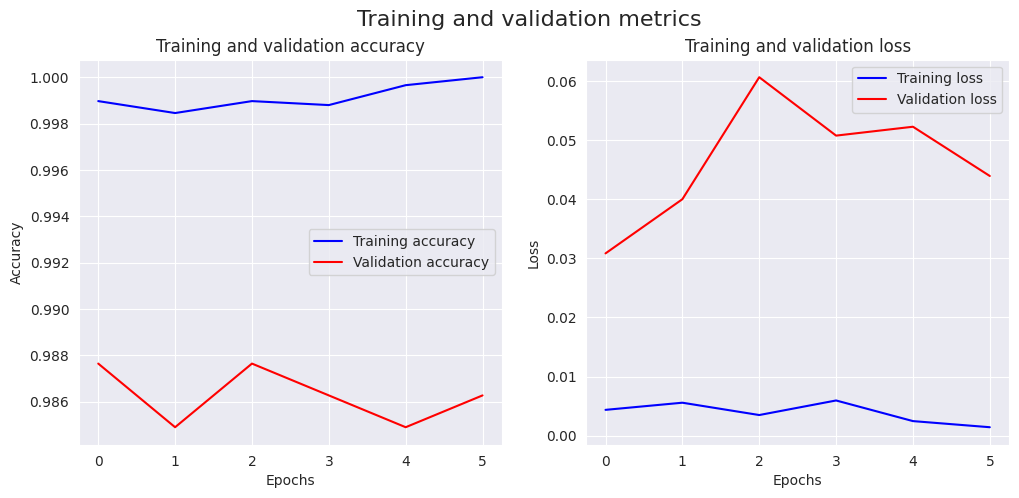

In [32]:
# Plotting training and validation accuracy and loss plots
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

## Data Augmentation

In [62]:
# Creating data augments and data generators
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)
# validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# test data
test_datagen = ImageDataGenerator()

image_size=(224,224)

# training data
train_generator = data_gen.flow_from_directory(
    train_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,  
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 5820 images belonging to 2 classes.
Found 728 images belonging to 2 classes.
Found 728 images belonging to 2 classes.


In [63]:
len(test_generator)

23

In [64]:
len(val_generator)

23

### 3. VGG19

In [43]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [44]:
# Train and fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
119/182 ━━━━━━━━━━━━━━━━━━━━ 30s 485ms/step - accuracy: 0.8305 - loss: 0.3839

W0000 00:00:1716826295.297374     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 97s 488ms/step - accuracy: 0.8582 - loss: 0.3317 - val_accuracy: 0.9712 - val_loss: 0.0828 - learning_rate: 1.0000e-04
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 89s 470ms/step - accuracy: 0.9637 - loss: 0.0996 - val_accuracy: 0.9808 - val_loss: 0.0591 - learning_rate: 1.0000e-04
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 88s 463ms/step - accuracy: 0.9751 - loss: 0.0793 - val_accuracy: 0.9821 - val_loss: 0.0441 - learning_rate: 1.0000e-04
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 88s 466ms/step - accuracy: 0.9829 - loss: 0.0519 - val_accuracy: 0.9849 - val_loss: 0.0433 - learning_rate: 1.0000e-04
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 89s 468ms/step - accuracy: 0.9821 - loss: 0.0547 - val_accuracy: 0.9890 - val_loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 89s 470ms/step - accuracy: 0.9901 - loss: 0.0271 - val_accuracy: 0.9808 - val_loss: 0.0558 - learning_rate: 1.0000e-04
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 89s 470ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step
Accuracy on Validation Set: 0.993132


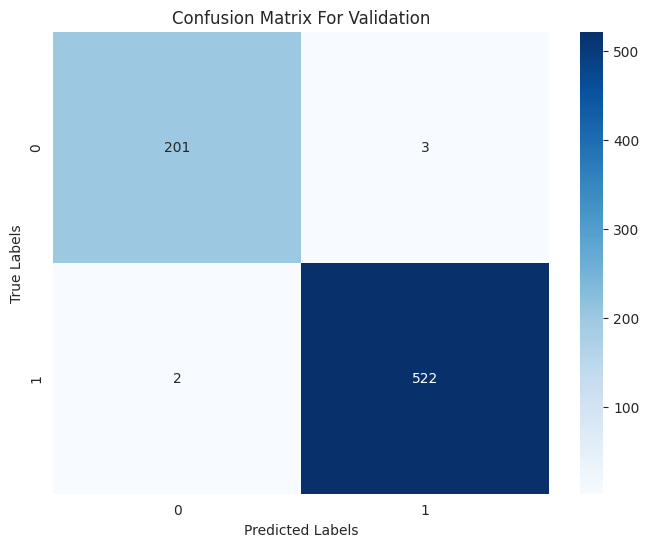

In [45]:
# Plot a confusion matrix
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

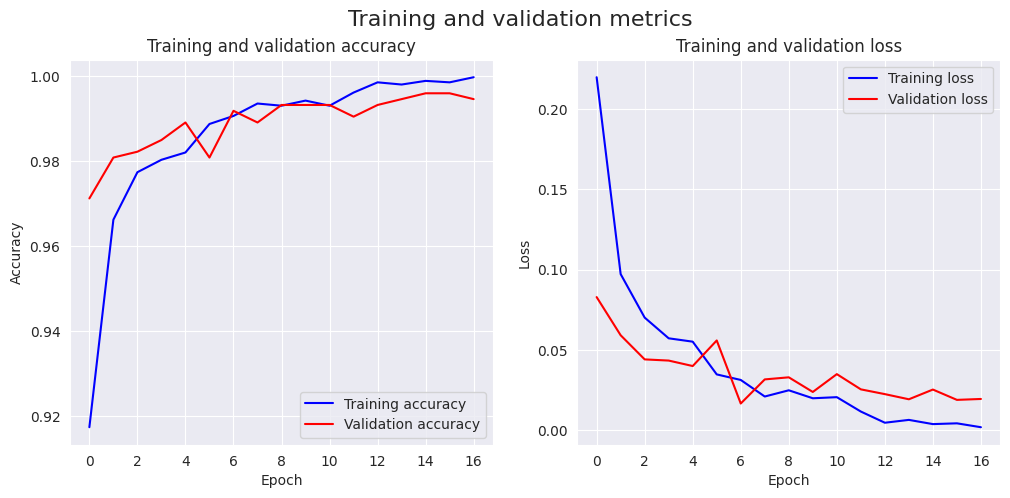

In [46]:
# Accuracy and Loss curves for training and validation
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

### 4. EfficientNet

In [52]:
# Create the model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [53]:
# train and fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/182 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.5234 - loss: 0.8044    

W0000 00:00:1716828508.039326     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/182 ━━━━━━━━━━━━━━━━━━━━ 57s 695ms/step - accuracy: 0.7751 - loss: 0.4764

W0000 00:00:1716828576.057881     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8191 - loss: 0.4135

W0000 00:00:1716828617.394744     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716828626.670385     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 157s 657ms/step - accuracy: 0.8198 - loss: 0.4124 - val_accuracy: 0.9574 - val_loss: 0.2005 - learning_rate: 1.0000e-04
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 86s 453ms/step - accuracy: 0.9323 - loss: 0.2155 - val_accuracy: 0.9629 - val_loss: 0.1397 - learning_rate: 1.0000e-04
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 86s 454ms/step - accuracy: 0.9481 - loss: 0.1611 - val_accuracy: 0.9643 - val_loss: 0.1113 - learning_rate: 1.0000e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 86s 450ms/step - accuracy: 0.9548 - loss: 0.1407 - val_accuracy: 0.9698 - val_loss: 0.1133 - learning_rate: 1.0000e-04
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 86s 453ms/step - accuracy: 0.9565 - loss: 0.1261 - val_accuracy: 0.9712 - val_loss: 0.1037 - learning_rate: 1.0000e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 86s 455ms/step - accuracy: 0.9576 - loss: 0.1355 - val_accuracy: 0.9725 - val_loss: 0.0930 - learning_rate: 1.0000e-04
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 86s 452ms/

 5/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

W0000 00:00:1716832375.762518     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step


W0000 00:00:1716832381.933847     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy on Validation Set: 0.989011


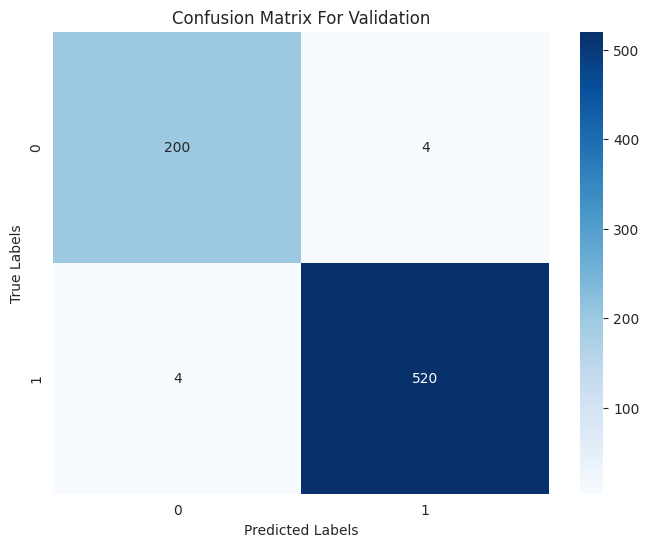

In [54]:
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Accuracy on Test Set: 0.982143


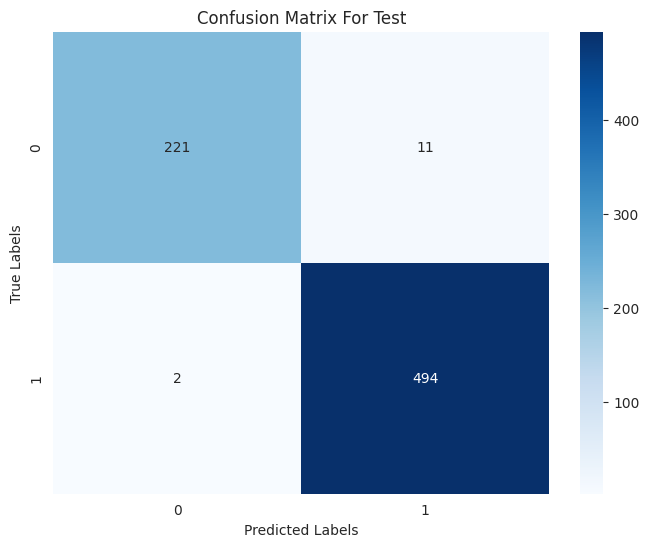

In [55]:
predictions = model.predict(X_test_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

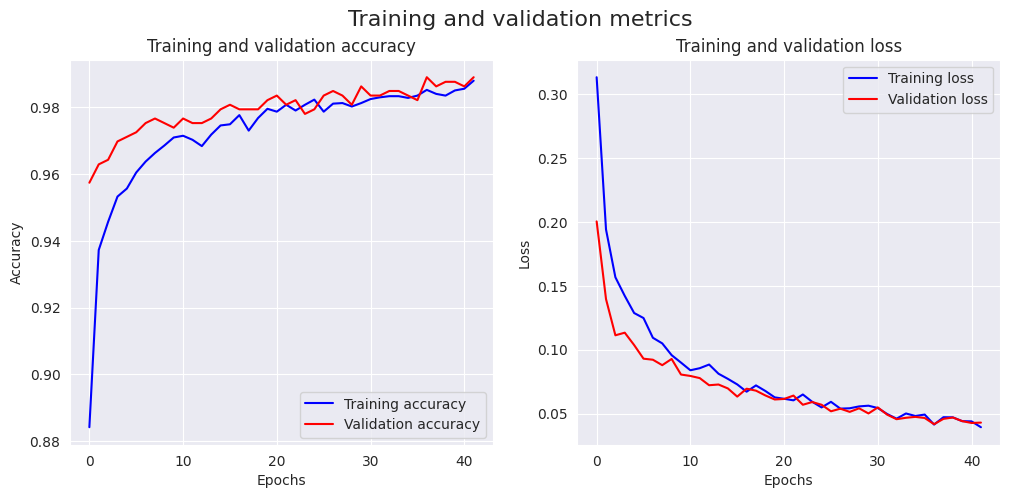

In [56]:
# Curves for accuracy and loss per epoch

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

## Model Evaluation

In [ ]:
results = model.evaluate(test_folder, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
y_test = list(test_folder.Label)
print(classification_report(y_test, pred))

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_folder)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')